In [1]:
from clustering import *
from downloaddata import *
from portfolio_and_performance import *
from trees import *
import cPickle as pickle

In [2]:
with open("SP500list.txt") as f:
    nodenames = f.read().splitlines()
data = get_quandl_data(nodenames, startdate='1900-01-01', enddate='2017-06-28')
data.to_csv("SP500_full.csv")

downloading MMM


downloading ABT


downloading ABBV


downloading ACN


downloading ATVI


downloading AYI


downloading ADBE


KeyboardInterrupt: 

In [2]:
window = 100
space = 10
thresh = 95
filename = "SP500_from_1985.csv"
enddate='2017-06-28'
startdate='1985-01-02'

In [42]:
data = importdata("SP500_full.csv")
startpos = int(np.where(data.index == startdate)[0])
existing_stocks = data.iloc[startpos:startpos+6].dropna(axis=1, how="all").columns
existing_prices = data[existing_stocks]
existing_prices.to_csv("SP500_from_1985.csv")

In [4]:
trees = construct_trees(filename=filename, thresh=thresh, window=window,
                        enddate=enddate,
                        startdate=startdate,
                        space=space, tree_type='MST')
sorteddates = sorted(trees.keys(), key=lambda d: map(int, d.split('-')))
IGtrees = {}
for key in sorteddates:
    IGtrees[key] = NXtoIG(trees[key])

In [ ]:
shrunk_trees = construct_trees(filename=filename, thresh=thresh, window=window,
                        enddate=enddate,
                        startdate=startdate,
                        space=space, tree_type='MST')
sorteddates = sorted(trees.keys(), key=lambda d: map(int, d.split('-')))
IGtrees = {}
for key in sorteddates:
    IGtrees[key] = NXtoIG(trees[key])

In [3]:
import gc
picklename = open('pickle/MST_WRDS_noshrinkage_spaced_1985.p', 'rb')
gc.disable()
trees = pickle.load(picklename)
gc.enable()
picklename.close()
picklename = open('pickle/MST_WRDS_LedoitWolf_spaced_1985.p', 'rb')
gc.disable()
shrunk_trees = pickle.load(picklename)
gc.enable()
picklename.close()

In [4]:
sorteddates = sorted(trees.keys(), key=lambda d: map(int, d.split('-')))

In [5]:
IGtrees = {}
for key in sorteddates:
    IGtrees[key] = NXtoIG(trees[key])

In [8]:
clustersNewman, IGclustersNewman = construct_clusters(IGtrees, method='Newman')
clustersClausetNewman, IGclustersClausetNewman = construct_clusters(IGtrees, method="ClausetNewman")

In [19]:
pickle.dump(clustersNewman,open("pickle/clustersNewman.p",'wb'))
pickle.dump(IGclustersNewman,open("pickle/IGclustersNewman.p",'wb'))
pickle.dump(clustersClausetNewman,open("pickle/clustersClausetNewman.p",'wb'))
pickle.dump(IGclustersClausetNewman,open("pickle/IGclustersClausetNewman.p",'wb'))

In [7]:
gc.disable()
picklename = open('pickle/unshrunk_clustersNewman.p', 'rb')
clustersNewman = pickle.load(picklename) 
picklename.close()
picklename = open('pickle/unshrunk_clustersClausetNewman.p', 'rb')
clustersClausetNewman = pickle.load(picklename) 
picklename.close()
picklename = open('pickle/unshrunk_IGclustersNewman.p', 'rb')
IGclustersNewman = pickle.load(picklename) 
picklename.close()
picklename = open('pickle/unshrunk_IGclustersClausetNewman.p', 'rb')
IGclustersClausetNewman = pickle.load(picklename) 
picklename.close()
gc.enable()

In [8]:
%matplotlib inline

Newman           23.836431
ClausetNewman    17.152416
dtype: float64


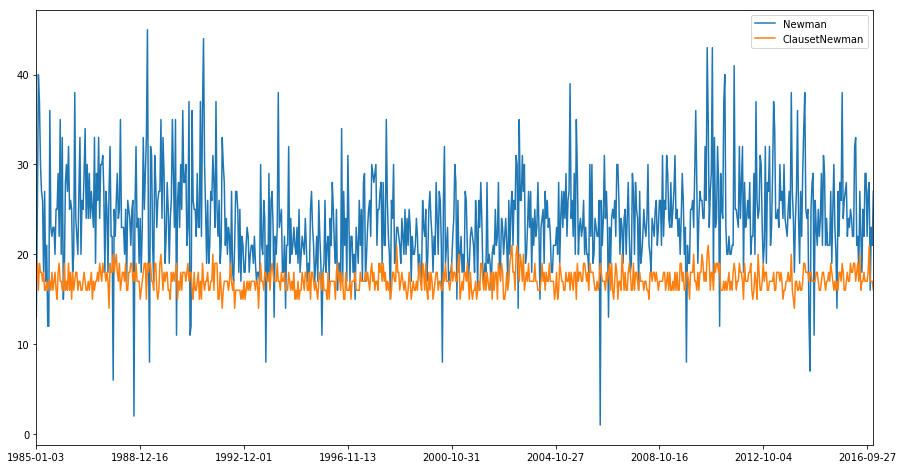

In [7]:
nofclusters = pd.DataFrame(index=sorteddates)
nofclusters['Newman'] = [len(clustersNewman[sorteddates[i]]) for i in range(0, len(sorteddates))]
nofclusters['ClausetNewman'] = [len(clustersClausetNewman[sorteddates[i]]) for i in range(0, len(sorteddates))]
print(np.mean(nofclusters))
%matplotlib inline
nofclusters.plot(figsize=(15, 8))

In [11]:
NewmanUniverse = {}
ClausetNewmanUniverse = {}
for measure in ['degree', 'closeness', 'betweenness']:
    NewmanUniverse[measure] = clustering_universe(trees, clustersNewman, measure, quantile=0)
    ClausetNewmanUniverse[measure] = clustering_universe(trees, clustersClausetNewman, 
                                                         measure, quantile=0)
universes = {'Newman': NewmanUniverse, 'ClausetNewman': ClausetNewmanUniverse}

In [12]:
pickle.dump(universes, open("pickle/universes_unshrunk.p", "wb"))

In [8]:
universes = pickle.load(open("pickle/universes_unshrunk.p", "rb"))

In [9]:
price = importdata("data/WRDS/SP500_price_1985.csv").replace(0,np.nan).ffill()

In [10]:
ret = importdata("data/WRDS/SP500_ret_1985.csv").fillna(0)
div = importdata("data/WRDS/SP500_div_1985.csv").fillna(0)
cpr = importdata("data/WRDS/SP500_cpr_1985.csv").replace(0,np.nan).ffill()

In [8]:
text_file = open("Central-NewmanBetweenness-SP500_1985.txt", "w")
for t in sorteddates:
    text_file.write('%s: ' % t)
    for stock in universes['Newman']['betweenness'][t]['central']:
        text_file.write('%s ' % stock)
    text_file.write('\n')
text_file.close()

In [11]:
performance_weighted, performance_unweighted = \
    benchmark_performance(price, ret, div, cpr, thresh=thresh,
                          universes=universes['Newman']['betweenness'],
                          window=window, shrinkage='None')
performance_comparison_weighted = {'benchmark': performance_weighted}
performance_comparison_unweighted = {'benchmark': performance_unweighted}

In [15]:
pickle.dump(performance_comparison_unweighted, open("pickle/performance_unshunk_unweighted.p", "wb"))
pickle.dump(performance_comparison_weighted, open("pickle/performance_unshunk_weighted.p", "wb"))

In [16]:
from threading import Thread

In [17]:
def compute_clustering_performance(price, ret, div, cpr, thresh, universes, record_dict, weighted='TRUE', window=100,
                                    shrinkage='None'):
    print "starting..."
    temp = clustering_performance(price, ret, div, cpr, thresh=thresh, universes=universes,
                                  weighted=weighted, window=window, shrinkage=shrinkage)
    record_dict[method][measure] = pd.DataFrame.from_dict(temp)
    record_dict[method][measure]['benchmark'] = performance_comparison_unweighted['benchmark'][
        'benchmark']
    record_dict[method][measure] = performance_comparison_unweighted[method][measure][[
        'benchmark', 'central', 'peripheral']]

In [18]:
threads = []
shrinkage = "None"
for method in ['Newman', 'ClausetNewman']:
    for measure in ['degree', 'closeness', 'betweenness']:
        process = Thread(target=compute_clustering_performance, args=[price, ret, div, cpr,
                                                                      thresh, universes[method][measure],
                                                                      performance_comparison_unweighted, "FALSE",
                                                                      window, shrinkage])
        process.start()
        threads.append(process)

        process = Thread(target=compute_clustering_performance, args=[price, ret, div, cpr,
                                                                      thresh, universes[method][measure],
                                                                      performance_comparison_weighted, 'TRUE', window,
                                                                      shrinkage])
        process.start()
        threads.append(process)
for process in threads:
    process.join()

starting...starting...
starting...starting...




starting...starting... starting...
starting...

starting...

starting...


starting...starting...



In [2]:
performance_comparison_unweighted['Newman']['degree']

NameError: name 'performance_comparison_unweighted' is not defined

In [15]:
import datetime
for method in ['Newman', 'ClausetNewman']:
    performance_comparison_unweighted[method] = {}
    for measure in ['degree', 'closeness', 'betweenness']:
         
        temp = clustering_performance(price, ret, div, cpr, thresh=thresh, universes=universes[method][measure],
                                      weighted='FALSE', window=window, shrinkage = "None")
        performance_comparison_unweighted[method][measure] = pd.DataFrame.from_dict(temp)
        performance_comparison_unweighted[method][measure]['benchmark'] = performance_comparison_unweighted['benchmark'][
            'benchmark']
        performance_comparison_unweighted[method][measure] = performance_comparison_unweighted[method][measure][[
            'benchmark', 'central', 'peripheral']]
        print "done"+ ": " + str(datetime.datetime.now().time())
for method in ['Newman', 'ClausetNewman']:
    performance_comparison_weighted[method] = {}
    for measure in ['degree', 'closeness', 'betweenness']:
        print "doing " + method + " " + measure+ ": " + str(datetime.datetime.now().time())
        temp = clustering_performance(price, ret, div, cpr, thresh=thresh, universes=universes[method][measure],
                                      weighted='TRUE', window=window,shrinkage = "None")
        performance_comparison_weighted[method][measure] = pd.DataFrame.from_dict(temp)
        performance_comparison_weighted[method][measure]['benchmark'] = performance_comparison_weighted['benchmark'][
            'benchmark']
        performance_comparison_weighted[method][measure] = performance_comparison_weighted[method][measure][[
            'benchmark', 'central', 'peripheral']]
        print "done"+ ": " + str(datetime.datetime.now().time())

doing Newman degree: 20:28:41.879075


done: 20:30:10.213996
doing Newman closeness: 20:30:10.214076


done: 20:31:37.538428
doing Newman betweenness: 20:31:37.538509


done: 20:33:05.493927
doing ClausetNewman degree: 20:33:05.494023


done: 20:34:32.832240
doing ClausetNewman closeness: 20:34:32.832331


done: 20:36:01.270116
doing ClausetNewman betweenness: 20:36:01.270201


done: 20:37:29.301474
doing Newman degree: 20:37:29.301887


done: 20:39:00.673281
doing Newman closeness: 20:39:00.673357


done: 20:40:35.808473
doing Newman betweenness: 20:40:35.808561


done: 20:42:11.215166
doing ClausetNewman degree: 20:42:11.215248


done: 20:43:40.521011
doing ClausetNewman closeness: 20:43:40.521133


done: 20:45:09.550320
doing ClausetNewman betweenness: 20:45:09.550403


done: 20:46:40.779934


In [28]:
shrinkage = 'None'

In [29]:
noclusteruniverse_0 = {}
performance_comparison_unweighted['nocluster'] = {}
for c_measure in ['degree', 'closeness', 'betweenness']:
    print "doing " + "nocluster" + " " + c_measure+ ": " + str(datetime.datetime.now().time())
    noclusteruniverse_0[c_measure] = no_cluster_universe(trees=trees, c_measure=c_measure, quantile=0.25)
    performance_comparison_unweighted['nocluster'][c_measure] = pd.DataFrame.from_dict(
        clustering_performance(price, ret, div, cpr, thresh=thresh, universes=noclusteruniverse_0[c_measure],
                               weighted='FALSE', window=window, shrinkage=shrinkage))
    print "done"+ ": " + str(datetime.datetime.now().time())

    #single nocluster universe, unweighted
single_noclusteruniverse = {}
performance_comparison_unweighted['single_nocluster'] = {}
for c_measure in ['degree', 'closeness', 'betweenness']:
    print "doing " + "single_cluster" + " " + c_measure+ ": " + str(datetime.datetime.now().time())
    single_noclusteruniverse[c_measure] = no_cluster_universe(trees=trees, c_measure=c_measure, quantile=0)
    performance_comparison_unweighted['single_nocluster'][c_measure] = pd.DataFrame.from_dict(
        clustering_performance(price, ret, div, cpr, thresh=thresh, universes=single_noclusteruniverse[c_measure],
                               weighted='FALSE', window=window, shrinkage=shrinkage))
    print "done"+ ": " + str(datetime.datetime.now().time())


    #no cluster universe, weighted--------------
noclusteruniverse_0 = {}
performance_comparison_weighted['nocluster'] = {}
for c_measure in ['degree', 'closeness', 'betweenness']:
    print "doing " + "nocluster" + " " + c_measure+ ": " + str(datetime.datetime.now().time())
    noclusteruniverse_0[c_measure] = no_cluster_universe(trees=trees, c_measure=c_measure, quantile=0.25)
    performance_comparison_weighted['nocluster'][c_measure] = pd.DataFrame.from_dict(
        clustering_performance(price, ret, div, cpr, thresh=thresh, universes=noclusteruniverse_0[c_measure],
                               weighted='TRUE', window=window, shrinkage=shrinkage))
    print "done"+ ": " + str(datetime.datetime.now().time())

    #single nocluster universe, weighted
single_noclusteruniverse = {}
performance_comparison_weighted['single_nocluster'] = {}
for c_measure in ['degree', 'closeness', 'betweenness']:
    print "doing " + "single_cluster" + " " + c_measure+ ": " + str(datetime.datetime.now().time())
    single_noclusteruniverse[c_measure] = no_cluster_universe(trees=trees, c_measure=c_measure, quantile=0)
    performance_comparison_weighted['single_nocluster'][c_measure] = pd.DataFrame.from_dict(
        clustering_performance(price, ret, div, cpr, thresh=thresh, universes=single_noclusteruniverse[c_measure],
                               weighted='TRUE', window=window, shrinkage=shrinkage))
    print "done"+ ": " + str(datetime.datetime.now().time())

doing nocluster degree: 21:32:52.688951


done: 21:34:21.781655
doing nocluster closeness: 21:34:21.781839


done: 21:38:34.441921
doing nocluster betweenness: 21:38:34.442013


done: 21:44:10.926839
doing single_cluster degree: 21:44:10.927313


done: 21:45:40.250694
doing single_cluster closeness: 21:45:40.250814


done: 21:49:50.998252
doing single_cluster betweenness: 21:49:50.998344


done: 21:55:28.954300
doing nocluster degree: 21:55:28.957010


done: 21:57:00.525352
doing nocluster closeness: 21:57:00.525516


done: 22:01:14.722903
doing nocluster betweenness: 22:01:14.722997


done: 22:07:00.904842
doing single_cluster degree: 22:07:00.906535


done: 22:08:37.553534
doing single_cluster closeness: 22:08:37.553618


done: 22:13:25.296973
doing single_cluster betweenness: 22:13:25.297085


done: 22:19:55.226828


In [71]:
pickle.dump(single_noclusteruniverse, open("pickle/single_nocluster_universe_unshrunk.p", "wb"))
pickle.dump(noclusteruniverse_0, open("pickle/nocluster_universe_unshrunk.p", "wb"))

In [30]:
pickle.dump(performance_comparison_unweighted, open("pickle/performance_unshunk_unweighted.p", "wb"))
pickle.dump(performance_comparison_weighted, open("pickle/performance_unshunk_weighted.p", "wb"))

In [11]:
performance_comparison_unweighted = pickle.load(open("pickle/performance_unshunk_unweighted.p", "rb"))
performance_comparison_weighted = pickle.load(open("pickle/performance_unshunk_weighted.p", "rb"))

In [73]:
single_noclusteruniverse['degree']

{'1985-01-03': {'central': ['12490'], 'peripheral': ['58246', '13928']},
 '1985-01-17': {'central': ['12490'], 'peripheral': ['58246', '21371']},
 '1985-01-31': {'central': ['12490'], 'peripheral': ['58246', '13928']},
 '1985-02-14': {'central': ['12490'], 'peripheral': ['21371', '58246']},
 '1985-03-01': {'central': ['12490'], 'peripheral': ['21371', '23393']},
 '1985-03-15': {'central': ['12490'], 'peripheral': ['37284', '13928']},
 '1985-03-29': {'central': ['12490'], 'peripheral': ['13928', '76639']},
 '1985-04-15': {'central': ['12490'], 'peripheral': ['13928', '37284']},
 '1985-04-29': {'central': ['12490'], 'peripheral': ['13928', '37284']},
 '1985-05-13': {'central': ['12060'], 'peripheral': ['37284', '13928']},
 '1985-05-28': {'central': ['12060'], 'peripheral': ['37284', '21371']},
 '1985-06-11': {'central': ['12060'], 'peripheral': ['37284', '13936']},
 '1985-06-25': {'central': ['12060'], 'peripheral': ['76639', '37284']},
 '1985-07-10': {'central': ['12490'], 'peripheral':

In [12]:
final_result = {'None':{'weighted':performance_comparison_weighted,'unweighted':performance_comparison_unweighted}}

In [48]:
legend_list = []
tmp = pd.to_datetime(final_result['None']['weighted']['ClausetNewman']['degree'].index)
fig, ax = plt.subplots(1, 1)

In [41]:
%matplotlib inline

In [49]:
for shrinkage in ['None']:
    for weighted in ['weighted']:
        for method in final_result[shrinkage][weighted].keys():
            if method != 'benchmark':
                for measure in ['betweenness']:
                    #final_result[shrinkage][weighted][method][measure].plot(figsize=(20, 8),ax=ax)
                    for column in ['central', 'peripheral']:
                        legend_list.append(shrinkage+weighted+method+measure+column)
                    tmp_DataFrame = final_result[shrinkage][weighted][method][measure].set_index(tmp)
                    tmp_DataFrame.plot(figsize=(20, 8),ax = ax)                  
            else:
                legend_list.append(shrinkage+weighted+method)
                final_result[shrinkage][weighted][method].plot(figsize=(20, 8), ax = ax)

ax.legend(legend_list)

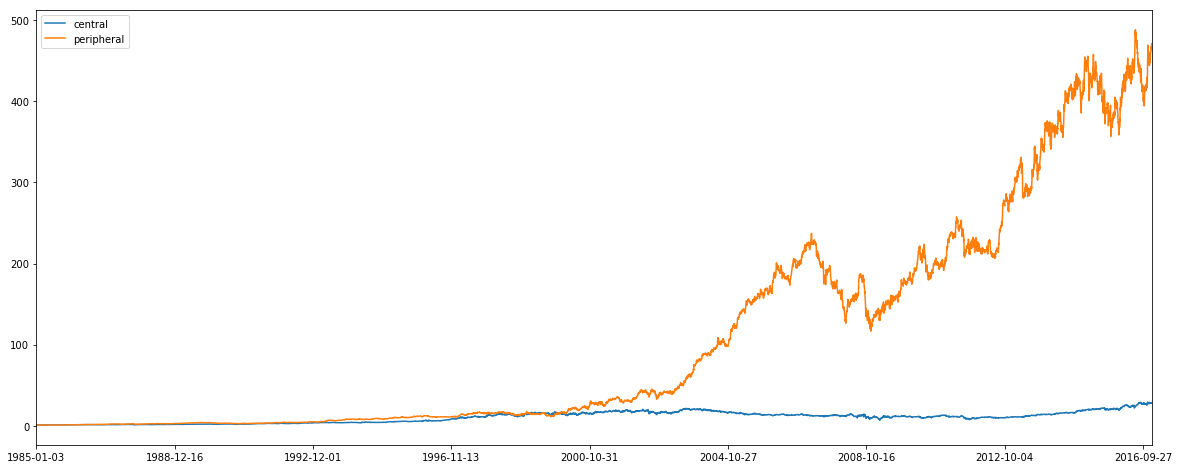

In [74]:
performance_comparison_weighted['single_nocluster']['degree'].plot(figsize=(20, 8))

In [19]:
fig = plt.figure()
performance_comparison_weighted['single_nocluster']['degree'].plot(figsize=(20, 8))
fig.text(.1,.1,shrinkage+'_'+weighted+'_'+method+'_'+measure)
plt.show()

In [25]:
import matplotlib as mpl
mpl.is_interactive()
from matplotlib import pyplot as plt
plt.ioff()

In [22]:
import matplotlib.pyplot as plt

%matplotlib
for shrinkage in ['None']:
    for weighted in ['weighted','unweighted']:
        for method in final_result[shrinkage][weighted].keys():
            if method != 'benchmark':
                for measure in ['betweenness','degree','closeness']:
                    fig = plt.figure()
                    final_result[shrinkage][weighted][method][measure].plot(figsize=(20, 8))
                    fig.text(.1,.1,shrinkage+'_'+weighted+'_'+method+'_'+measure)
                    plt.savefig("Graphs/"+shrinkage+'_'+weighted+'_'+method+'_'+measure+".pdf", bbox_inches='tight')
            else:
                final_result[shrinkage][weighted][method].plot(figsize=(20, 8))
                plt.savefig("Graphs/"+shrinkage+'_'+weighted+'_'+method+'_'+".pdf", bbox_inches='tight')

Using matplotlib backend: Qt5Agg


In [79]:
performance_comparison_weighted['single_nocluster']['degree']['2012-05-04':'2012-10-18'].to_csv("analysis.csv")

In [21]:
for shrinkage in ['None']:
    for weighted in ['weighted','unweighted']:
        for method in final_result[shrinkage][weighted].keys():
            if method != 'benchmark':
                for measure in ['betweenness','degree','closeness']:
                    for port in ['central','peripheral']:
                        print("%s: %f" % (shrinkage+'_'+weighted+'_'+method+'_'+measure+'_'+port
                                          , sharpe_ratio(
                            final_result[shrinkage][weighted][method][measure][port],0.01)))
            else:
                print("%s: %f" % (shrinkage+'_'+weighted+'_'+method
                                          , sharpe_ratio(
                            final_result[shrinkage][weighted][method]['benchmark'],0.01)))

None_weighted_Newman_betweenness_central: 0.712797
None_weighted_Newman_betweenness_peripheral: 1.015834
None_weighted_Newman_degree_central: 0.717881
None_weighted_Newman_degree_peripheral: 0.919497
None_weighted_Newman_closeness_central: 0.793827
None_weighted_Newman_closeness_peripheral: 0.909553
None_weighted_benchmark: 0.903382
None_weighted_ClausetNewman_betweenness_central: 0.506679
None_weighted_ClausetNewman_betweenness_peripheral: 1.020761
None_weighted_ClausetNewman_degree_central: 0.572815
None_weighted_ClausetNewman_degree_peripheral: 0.927211
None_weighted_ClausetNewman_closeness_central: 0.617496
None_weighted_ClausetNewman_closeness_peripheral: 0.910924
None_weighted_nocluster_betweenness_central: 0.673821
None_weighted_nocluster_betweenness_peripheral: 1.018595
None_weighted_nocluster_degree_central: 0.673454
None_weighted_nocluster_degree_peripheral: 0.929432
None_weighted_nocluster_closeness_central: 0.694232
None_weighted_nocluster_closeness_peripheral: 0.886595
Non

In [19]:
print "Sharpe ratios:"
for port in ['central','peripheral','benchmark']:
    print("%s: %f" % (port, sharpe_ratio(performance_comparison_weighted['Newman']['betweenness'][port],0.01)))

Sharpe ratios:
central: 0.712797
peripheral: 1.015834
benchmark: 0.903382


In [19]:
noclusteruniverse_0 = no_cluster_universe(trees=trees, c_measure='betweenness', quantile=0)

In [20]:
performance_comparison_weighted['nocluster'] = pd.DataFrame.from_dict(
    clustering_performance(price, ret, div, cpr, thresh=thresh, universes=noclusteruniverse,
                           weighted='FALSE', window=window, shrinkage='None'))

NameError: name 'noclusteruniverse' is not defined

In [68]:
nocluster_performance_0 = pd.DataFrame.from_dict(
    clustering_performance(price, ret, div, cpr, thresh=thresh, universes=noclusteruniverse_0,
                           weighted='FALSE', window=window,shrinkage='None'))

In [59]:
performance_comparison_weighted['Newman']['betweenness']['central-no_clusters'] = \
performance_comparison_weighted['nocluster']['central']
performance_comparison_weighted['Newman']['betweenness']['peripheral-no_clusters'] = \
performance_comparison_weighted['nocluster']['peripheral']

In [69]:
performance_comparison_weighted['Newman']['betweenness']['single-central-no_clusters'] = \
nocluster_performance_0['central']
performance_comparison_weighted['Newman']['betweenness']['single-peripheral-no_clusters'] = \
nocluster_performance_0['peripheral']

In [56]:
sharpe_ratio(performance_comparison_weighted['nocluster']['peripheral'], 0.01)

0.92558501467796217

In [48]:
def no_cluster_universe(trees, c_measure, quantile=0.25):
    result = {}
    sorteddates = sorted(trees.keys(), key=lambda d: map(int, d.split('-')))
    for k in sorteddates:
        T = trees[k]
        subresult = {}
        peripheral = []
        central = []
        peripheral.extend(portfolio(T, c_measure, quantile, "lower"))
        central.extend(portfolio(T, c_measure, quantile, "upper"))
        subresult["central"] = central
        subresult["peripheral"] = peripheral
        result[k] = subresult
    return result

In [34]:
price = performance_comparison_weighted['Newman']['betweenness']['peripheral']

In [35]:
ret = price / price.shift(1)
ret = ret.iloc[1:] - 1
mean_ret = np.mean(ret)
std = np.std(ret)

In [37]:
mean_ret*252

0.12882054905202417

In [36]:
std*np.sqrt(252)

0.11994318170350765

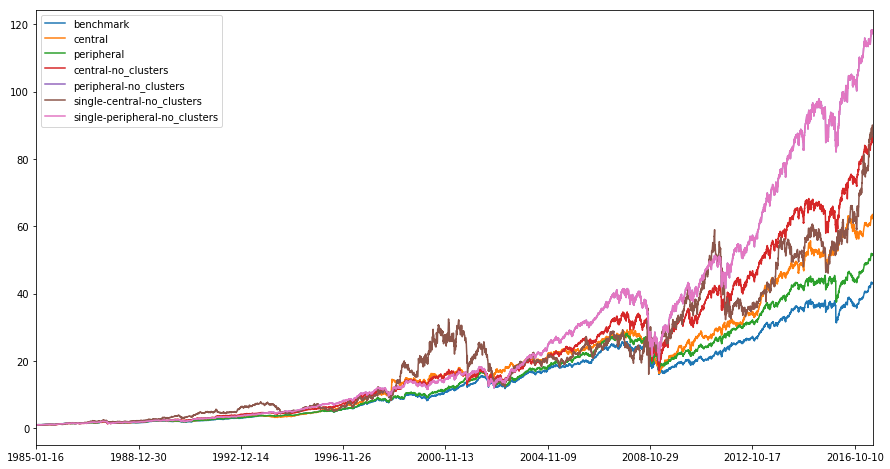

In [76]:
%matplotlib inline

performance_comparison_weighted['Newman']['betweenness'].plot(figsize=(15, 8))

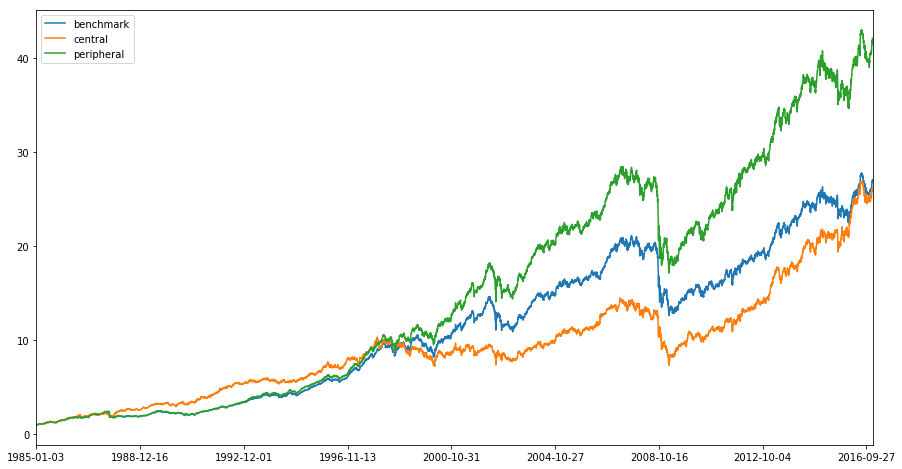

In [21]:
%matplotlib inline

performance_comparison_weighted['Newman']['betweenness'].plot(figsize=(15, 8))

In [80]:
universes['Newman']['closeness']

{'1985-01-16': {'central': ['AXP',
   'EMR',
   'WMT',
   'HPQ',
   'INTC',
   'ABT',
   'IBM',
   'XOM',
   'ED',
   'MRK',
   'ETN',
   'JPM',
   'HD',
   'TXN',
   'DTE',
   'DD'],
  'peripheral': ['ADP',
   'UTX',
   'NOC',
   'CNP',
   'AFL',
   'BK',
   'AAPL',
   'RTN',
   'DNB',
   'ADI',
   'BAX',
   'XRX',
   'CL',
   'HUM',
   'VLO',
   'COP',
   'TSO',
   'FRT',
   'HRS',
   'APD',
   'COO',
   'TGT',
   'WHR',
   'WMB',
   'HD',
   'TXN',
   'PSA',
   'WFC',
   'PNR',
   'NKE',
   'NWL',
   'PNW',
   'MDT']},
 '1985-01-30': {'central': ['IBM',
   'ED',
   'DD',
   'F',
   'UNP',
   'PFE',
   'ABT',
   'WMT',
   'HST',
   'R',
   'HES',
   'INTC',
   'LMT',
   'MAT',
   'AET',
   'MMM',
   'AME',
   'C',
   'AMGN',
   'TSO',
   'FL',
   'NKE'],
  'peripheral': ['CI',
   'NUE',
   'FRT',
   'CNP',
   'BDX',
   'PEP',
   'WMB',
   'IP',
   'CAT',
   'HON',
   'MRO',
   'LLY',
   'BAX',
   'HUM',
   'BK',
   'TGT',
   'IFF',
   'CAG',
   'DIS',
   'PSA',
   'HP',
   'COP',
   

In [31]:
print "Sharpe ratios:"
for port in ['central', 'peripheral', 'benchmark', 'central-no_clusters', 'peripheral-no_clusters',
             'single-central-no_clusters', 'single-peripheral-no_clusters']:
    print("%s: %f" % (port, sharpe_ratio(performance_comparison_weighted['Newman']['betweenness'][port], 0.01)))

Sharpe ratios:
central: 0.712797
peripheral: 1.015834
benchmark: 0.903382


KeyError: 'central-no_clusters'

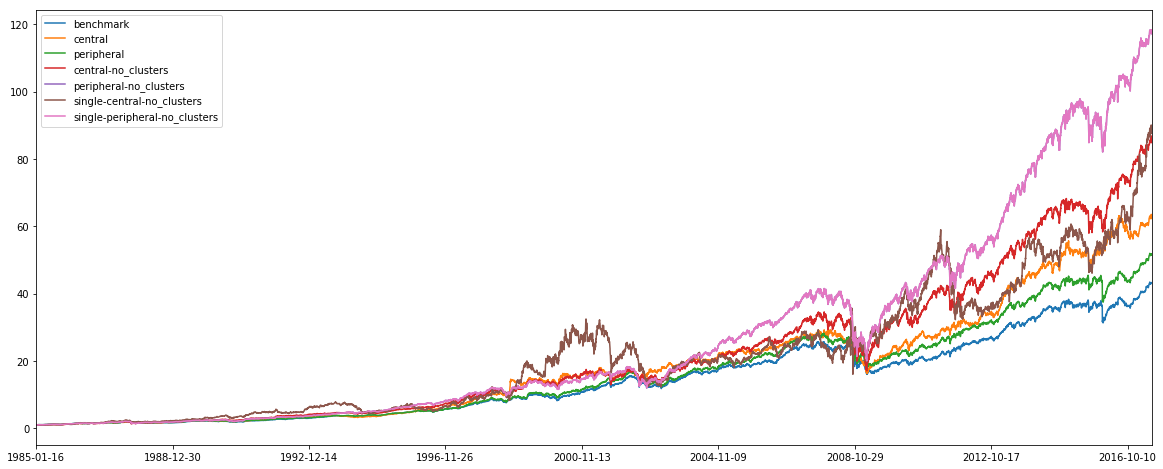

In [82]:
import matplotlib.pyplot as plt
performance_comparison_weighted['Newman']['betweenness'].plot(figsize=(20, 8))

plt.savefig("SP500NewmanBetweennessWeighted_with_single.pdf", bbox_inches='tight')